In [1]:
# TODO
# add graticules

In [2]:
# Code to Fig. 1 of Sauthoff and others, 2024
# This code requires a 32 gb server or local memory
#
# Written 2023-07-06 by W. Sauthoff (sauthoff@mines.edu)

# Setup computing environment

In [3]:
# Install dependency not pre-installed in CryoCloud
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import packages
import earthaccess
import geopandas as gpd
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import rioxarray
import xarray as xr

# Magic functions
%matplotlib widget
# %matplotlib inline

# Update the default font to Arial (and add backup if not found)
plt.rcParams['font.family'] = ['sans-serif']

# Define data directories dependent on home environment
# replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos_my/script_dir'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/'
elif os.getenv('HOME') == '/Users/Wilson': 
    DATA_DIR = '/Volumes/ExtremeSSD/data'
    SCRIPT_DIR = '/Users/Wilson/Documents/0-code/repos_my/script_dir'
    OUTPUT_DIR = '/Users/Wilson/Documents/0-code/1_outlines_candidates/output'

# Import datasets

In [5]:
# Import MODIS Mosaic of Antarctica surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
moa_lowres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa750_2014_hp1_v01.tif' 
# moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif' 

# Open into an xarray.DataArray, convert to dataset, and display
moa_da = rioxarray.open_rasterio(moa_lowres)

In [6]:
# Import MODIS MOA 2009 and 2014 coastline and grounding line for plotting inset maps
# # https://nsidc.org/data/nsidc-0593/versions/1
# shp = DATA_DIR + '/boundaries/MODIS-MOA/2009/moa_2009_coastline_v02.0.shp' 
# moa_2009_coastline = gpd.read_file(shp)
# shp = DATA_DIR + '/boundaries/MODIS-MOA/2009/moa_2009_groundingline_v02.0.shp' 
# moa_2009_groundingline = gpd.read_file(shp)

# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)

In [7]:
# Find cloud-hosted MEaSUREs Phase-Based Antarctica Ice Velocity Map, Version 1
# DOI from https://nsidc.org/data/NSIDC-0754/versions/1
results = earthaccess.search_data(
    doi='10.5067/PZ3NJ5RXRH10',
    cloud_hosted=True,
    bounding_box=(1, -89, -1, -89)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 1


In [8]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)
files

Opening 1 granules, approx size: 6.49 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0754.001/1996.01.01/antarctic_ice_vel_phase_map_v01.nc>]

In [9]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ice_vel = xr.open_dataset(files[0])
ice_vel

<xarray.Dataset> Size: 7GB
Dimensions:       (x: 12445, y: 12445)
Coordinates:
  * x             (x) float64 100kB -2.8e+06 -2.8e+06 ... 2.799e+06 2.8e+06
  * y             (y) float64 100kB 2.8e+06 2.8e+06 ... -2.799e+06 -2.8e+06
    lat           (y, x) float64 1GB ...
    lon           (y, x) float64 1GB ...
Data variables:
    coord_system  |S1 1B ...
    VX            (y, x) float32 620MB ...
    VY            (y, x) float32 620MB ...
    STDX          (y, x) float32 620MB ...
    STDY          (y, x) float32 620MB ...
    ERRX          (y, x) float32 620MB ...
    ERRY          (y, x) float32 620MB ...
    CNT           (y, x) int32 620MB ...
    SOURCE        (y, x) int8 155MB ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

In [10]:
# Specify the variables to keep
variables_to_keep = ['x', 'y', 'VX', 'VY']

variables_to_drop = [var for var in ice_vel.variables if var not in variables_to_keep]

# Drop variables to reduce memory consumption
ice_vel = ice_vel.drop_vars(variables_to_drop)
ice_vel

<xarray.Dataset> Size: 1GB
Dimensions:  (x: 12445, y: 12445)
Coordinates:
  * x        (x) float64 100kB -2.8e+06 -2.8e+06 ... 2.799e+06 2.8e+06
  * y        (y) float64 100kB 2.8e+06 2.8e+06 2.799e+06 ... -2.799e+06 -2.8e+06
Data variables:
    VX       (y, x) float32 620MB ...
    VY       (y, x) float32 620MB ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

In [11]:
# Calculate velocity magnitude
vel_mag = (ice_vel['VX']**2 + ice_vel['VY']**2)**0.5

In [12]:
del ice_vel

In [13]:
# Scripps Grounding Line (Depoorter and others, 2013)
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [14]:
# Import subglacial lake outlines 
exec(open(SCRIPT_DIR + '/Sauthoff2024_outlines.py').read())

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [15]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

# Figure generation

In [16]:
moa_2014_coastline.bounds

,minx,miny,maxx,maxy
0,-2.508075e+06,-2.143925e+06,2.747706e+06,2.245575e+06


In [17]:
moa_2014_coastline.bounds.minx

0   -2.508075e+06
Name: minx, dtype: float64

In [18]:
moa_2014_coastline.bounds.minx[0]

-2508075.0000018547

In [19]:
Scripps_landice.bounds

,minx,miny,maxx,maxy
1010,-2.507803e+06,-2.144005e+06,2.601876e+06,2.158549e+06


In [20]:
Scripps_landice.bounds.minx

1010   -2.507803e+06
Name: minx, dtype: float64

In [21]:
Scripps_landice.bounds.minx.values[0]

-2507802.8669891283

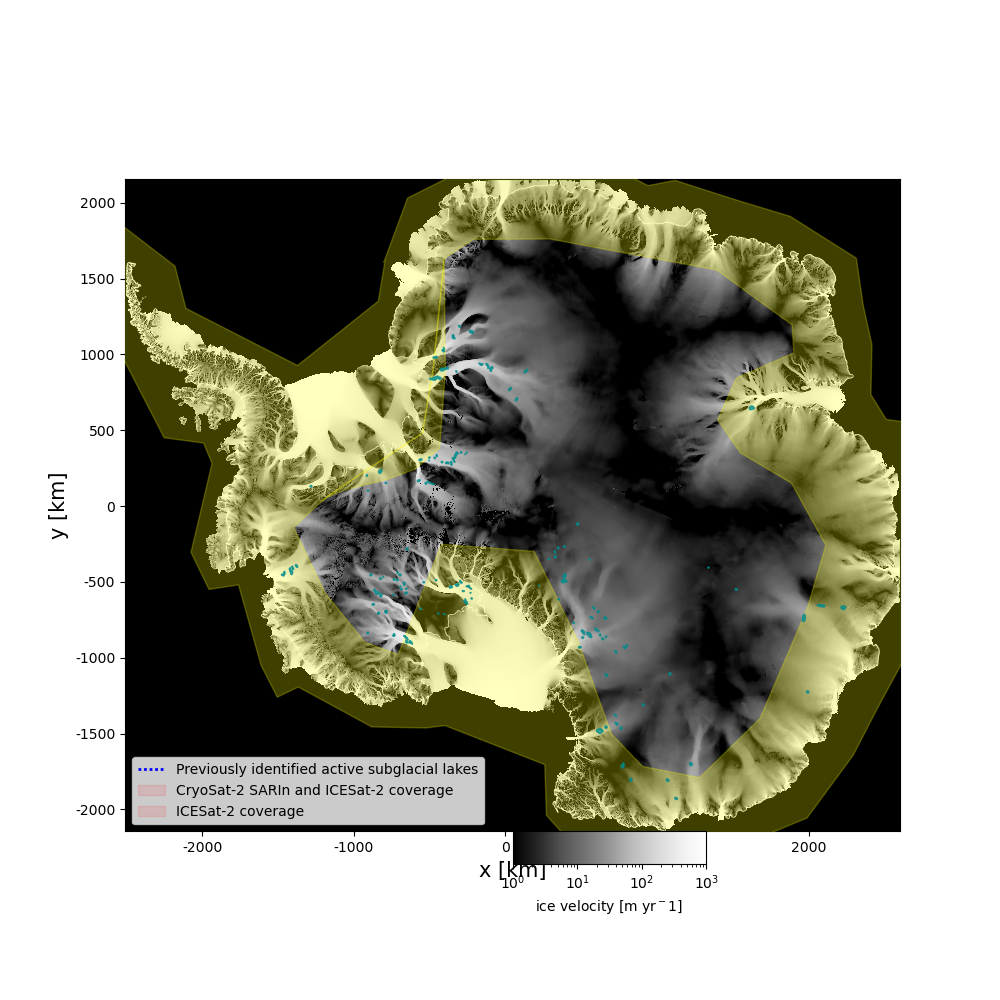

In [22]:
# Get the minimum and maximum values of the x and y dimensions
# x_min, x_max = moa_ds['x'].min(), moa_ds['x'].max()
# y_min, y_max = moa_ds['y'].min(), moa_ds['y'].max()
x_min, x_max = Scripps_landice.bounds.minx.values[0], Scripps_landice.bounds.maxx.values[0]
y_min, y_max = Scripps_landice.bounds.miny.values[0], Scripps_landice.bounds.maxy.values[0]

# Create fig and axes objects
fig, ax = plt.subplots(figsize=(10,10))

# Set the background color of the plotting area
ax.set_facecolor('k')

# Plot MOA imagery  
# ax.imshow(moa_da[0,:,:], cmap="gray", clim=[13000, 17000], extent=[x_min, x_max, y_min, y_max])

# Plot ice-surface velocity
# cax = vel_mag.plot(ax=ax, cmap='Greys_r', norm=LogNorm(vmin=vel_mag.min(), vmax=vel_mag.max()), zorder=2)
cax = vel_mag.plot(ax=ax, cmap='Greys_r', norm=LogNorm(vmin=1, vmax=1000), zorder=1, add_colorbar=False)

# Plot Scripps grounding line
# Scripps_landice.boundary.plot(ax=ax, linewidth=0.5, edgecolor='white', facecolor='k', zorder=1)  # Use black facecolor to fill in gaps in velocity array
Scripps_landice.boundary.plot(ax=ax, linewidth=0.5, edgecolor='white', facecolor='none', zorder=2)

# # Plot MOA coast and grounding lines  
# moa_2014_coastline.plot(ax=ax, color='gray', edgecolor='k', linewidth=0.1, zorder=1)
# moa_2014_groundingline.plot(ax=ax, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=1)

# Plot CryoSat-2 SARIn mode masks
gdf_SARIn_3_1.plot(ax=ax, edgecolor='yellow', facecolor='yellow', alpha=0.25, zorder=3)
gdf_SARIn_3_1_3_6_diff.plot(ax=ax, edgecolor='yellow', facecolor='yellow', alpha=0.25, zorder=3)

# Overlay published active subglacial lake outlines as translucent polygon and dotted line outlines 
# Smith2009_outlines.boundary.plot(ax=ax, facecolor='darkcyan', edgecolor='darkcyan', extent=[x_min, x_max, y_min, y_max], linewidth=1, alpha=0.75)
# Smith2009_outlines.boundary.plot(ax=ax, edgecolor='darkturquoise', linestyle=(0, (1, 5)), linewidth=1)
SiegfriedFricker2018_outlines.boundary.plot(ax=ax, facecolor='darkcyan', edgecolor='darkcyan', linewidth=1, alpha=0.75, zorder=4)
# SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='darkcyan', linestyle=(0, (1, 1)), linewidth=1)

# Create lines for legend
# Smith2009 = plt.Line2D((0, 1), (0, 0), color='darkturquoise', linestyle=(0, (1, 5)), linewidth=2)
static_lakes_line = plt.Line2D((0, 1), (0, 0), color='blue', linestyle=(0, (1, 1)), linewidth=2)
# Livingstone2023 = plt.Line2D((0, 1), (0, 0), color='darkslategray', linestyle=(0, (1, 1)), linewidth=2)

# Creating custom legend entries
CS2_SARIn_patch = mpatches.Patch(edgecolor='red', facecolor='red', alpha=0.1)
IS2_patch = mpatches.Patch(edgecolor='red', facecolor='red', alpha=0.1)

# Create legend
ax.legend([static_lakes_line, CS2_SARIn_patch, IS2_patch],
    ['Previously identified active subglacial lakes', 'CryoSat-2 SARIn and ICESat-2 coverage', 'ICESat-2 coverage'], 
    loc='lower left')

# Change polar stereographic m to km
km_scale = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
ax.yaxis.set_major_formatter(ticks_y)  

# Label axes
ax.set_xlabel('x [km]', size=15)
ax.set_ylabel('y [km]', size=15)

# Set axes limits
x_buffer, y_buffer = 1000, 1000
ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
# ax.set_xlim([x_min-x_buffer, x_max+x_buffer])
# ax.set_ylim([y_min-y_buffer, y_max+y_buffer])

# Plot colorbar
# Creating an inset of width "5%" and height "50%" of the parent axes' bounding box,
# positioned at the upper right corner (loc='upper right') with border padding of 0.05 and 0.01
axins = inset_axes(ax, width="50%", height="5%", loc='lower right',
                   bbox_to_anchor=(0.25, -0.05, 0.5, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0)
fig.colorbar(cax, cax=axins, label='ice velocity [m yr$^-1$]', orientation='horizontal')

plt.show()